<a href="https://colab.research.google.com/github/helloourworld/5MinuteFinance/blob/master/CONCRETUM_RESEARCH_QuanTips_1_Tactical_Asset_Allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Tactical Asset Allocation

**Updated Results and Real-Market Implementation**  
[**Mohamed Gabriel**](https://www.linkedin.com/in/msmgabriel/), [**Alberto Pagani**](https://www.linkedin.com/in/alberto-pagani-a36075209/), [**Carlo Zarattini**](https://www.linkedin.com/in/carlozarattini/)  
*QuanTips #1 — April 2025*  
[www.concretumgroup.com](https://www.concretumgroup.com) | info@concretumgroup.com

---

This notebook presents an updated implementation of the trend-following Tactical Asset Allocation strategy introduced by Meb Faber in *A Quantitative Approach to Tactical Asset Allocation* (2006). Using adjusted price data through March 2025, we evaluate the strategy's signals and simulate allocations across a diversified ETF universe.

Users can export their trade orders as a Trader Workstation-compatible basket file or automate execution via the Interactive Brokers API.

This notebook enables you to:

- Generate trend-following signals using a 200-day simple moving average (SMA)  
- Allocate capital across ETFs with equal weighting among active signals  
- Calculate precise trade instructions based on current holdings  
- Export and transmit Market-On-Close (MOC) orders via IBKR  
- Automate the full pipeline using free data from Polygon.io

## Step 0: Initial Setup (API Key, Tier, Packages, Imports)


### 1. Insert Your Polygon.io API Key
Replace the placeholder value in the cell below with your actual API key:


In [1]:
POLYGON_API_KEY = 'Xp2tG63ZGVB520jcXan7EEq6IOBopJ6d'

### 2. Set Subscription Tier
Set `POLYGON_SUBSCRIPTION_PAID = False` if you're on the **free** tier.  
Set `POLYGON_SUBSCRIPTION_PAID = True` if you have a **paid** plan.

In [3]:
POLYGON_SUBSCRIPTION_PAID = False

### 3. Install Required Packages

In [4]:
!pip install ipywidgets pandas numpy requests matplotlib ib_async

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.9 MB/s eta 0:00:00


### 4.  Import Required Libraries

In [5]:
import ipywidgets as widgets
from IPython.display import display, clear_output


import time
from functools import wraps


import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta


import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

import csv

from ib_async import IB, Stock, Order, util


# Step 1: Portfolio Configuration

Use the interactive widgets below to input:
- Total portfolio AUM  
- Current holdings for each ETF  

This data will be used to compute rebalancing instructions based on current market conditions.

In [6]:
import ipywidgets as widgets
from IPython.display import display

tickers = ["SPY", "EFA", "IEF", "VNQ", "DBC", "SHV"]

print("=== Portfolio Setup ===")

aum_widget = widgets.FloatText(
    value=100000.0,
    description='AUM ($):',
    style={'description_width': '100px'},
    step=1000,
    layout=widgets.Layout(width='300px')
)

share_widgets = {
    ticker: widgets.FloatText(
        value=100 if ticker != "SHV" else 0,
        description=f"{ticker} Shares:",
        style={'description_width': '100px'},
        layout=widgets.Layout(width='300px')
    )
    for ticker in tickers
}

output = widgets.Output()

portfolio_state = {
    "aum": None,
    "tickers_data": []
}

def on_submit_clicked(b):
    output.clear_output()
    with output:
        aum = aum_widget.value
        tickers_data = [
            {"ticker": t, "current_shares": share_widgets[t].value}
            for t in tickers
        ]
        portfolio_state["aum"] = aum
        portfolio_state["tickers_data"] = tickers_data
        print("Inputs submitted. Ready to fetch data and compute signals.")
        print(f"AUM: ${aum:,.2f}")
        for t in tickers_data:
            print(f"{t['ticker']}: {t['current_shares']} shares")

submit_button = widgets.Button(
    description="Submit Portfolio",
    button_style='success',
    layout=widgets.Layout(width='300px')
)
submit_button.on_click(on_submit_clicked)

col1 = widgets.VBox(list(share_widgets.values())[:3])
col2 = widgets.VBox(list(share_widgets.values())[3:])
form_layout = widgets.VBox([
    aum_widget,
    widgets.HBox([col1, col2]),
    submit_button,
    output
])
display(form_layout)


=== Portfolio Setup ===


# Step 2: Fetch and Adjust Market Data

We use the Polygon.io API to:
- Retrieve historical daily price data  
- Apply dividends and stock split adjustments  
- Compute adjusted total return prices for SMA signal generation  


In [7]:
end_date = datetime.now().date()
start_date = end_date - timedelta(days=365)
from_date = start_date.strftime('%Y-%m-%d')
to_date = end_date.strftime('%Y-%m-%d')
today = end_date.strftime('%Y-%m-%d')


# --- Rate Limiting for Polygon Free Tier ---
last_request_time = [0]

def rate_limit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        if not POLYGON_SUBSCRIPTION_PAID:
            elapsed = time.time() - last_request_time[0]
            min_interval = 12  # 5 requests/minute = 12 sec/request
            if elapsed < min_interval:
                wait_time = min_interval - elapsed
                print(f"[Rate Limit] Sleeping for {wait_time:.2f} seconds...")
                time.sleep(wait_time)
        result = func(*args, **kwargs)
        last_request_time[0] = time.time()
        return result
    return wrapper

@rate_limit
def polygon_daily(ticker, start_date, end_date):
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start_date}/{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={POLYGON_API_KEY}"
    response = requests.get(url)
    data = response.json()

    if 'results' not in data or not data['results']:
        return pd.DataFrame()

    df = pd.DataFrame(data['results'])
    df['date'] = pd.to_datetime(df['t'], unit='ms')
    df = df.rename(columns={
        'o': 'open',
        'h': 'high',
        'l': 'low',
        'c': 'close',
        'v': 'volume',
        'vw': 'vwap',
        'n': 'num_trades'
    })

    return df[['date', 'open', 'high', 'low', 'close', 'volume', 'vwap', 'num_trades']]

@rate_limit
def polygon_splits(ticker):
    url = f"https://api.polygon.io/v3/reference/splits?ticker={ticker}&limit=1000&apiKey={POLYGON_API_KEY}"
    response = requests.get(url)
    data = response.json()

    if 'results' not in data or not data['results']:
        return pd.DataFrame()

    df = pd.DataFrame(data['results'])
    df = df[['execution_date', 'split_from', 'split_to']]
    df['execution_date'] = pd.to_datetime(df['execution_date'])
    df = df.sort_values('execution_date')
    df['split_ratio'] = df['split_to'] / df['split_from']
    return df.reset_index(drop=True)


@rate_limit
def polygon_dividends(ticker):
    url = f"https://api.polygon.io/v3/reference/dividends?ticker={ticker}&limit=1000&apiKey={POLYGON_API_KEY}"
    response = requests.get(url)
    data = response.json()

    if 'results' not in data or not data['results']:
        return pd.DataFrame()

    df = pd.DataFrame(data['results'])
    df = df[['ex_dividend_date', 'cash_amount']]
    df['ex_dividend_date'] = pd.to_datetime(df['ex_dividend_date'])
    df = df.sort_values('ex_dividend_date')
    return df.reset_index(drop=True)


def apply_corporate_actions(df, splits, dividends):
    if df.empty:
        return df

    df = df.copy()
    df['split'] = 0.0
    df['dividend_raw'] = 0.0

    for _, row in splits.iterrows():
        ex_date = row['execution_date'].date()
        idx = (df['date'].dt.date - ex_date).abs().idxmin()
        if abs((df.loc[idx, 'date'].date() - ex_date).days) < 1:
            df.loc[idx, 'split'] = row['split_to'] / row['split_from']

    for _, row in dividends.iterrows():
        ex_date = row['ex_dividend_date'].date()
        idx = (df['date'].dt.date - ex_date).abs().idxmin()
        if abs((df.loc[idx, 'date'].date() - ex_date).days) < 1:
            df.loc[idx, 'dividend_raw'] = row['cash_amount']

    split_ratio = df['split'].replace(0, 1).values
    split_adj = np.roll(np.flip(np.cumprod(np.flip(split_ratio))), -1)
    split_adj[-1] = 1.0

    df['open_'] = df['open'] * split_adj
    df['high_'] = df['high'] * split_adj
    df['low_'] = df['low'] * split_adj
    df['close_'] = df['close'] * split_adj
    df['dividend'] = df['dividend_raw'] / split_adj

    df['daily_move_1d'] = df['close'].diff(1)
    df['tot_ret_1d'] = (df['daily_move_1d'] + df['dividend']) / df['close'].shift(1)

    factor = np.flip(df['tot_ret_1d'].values)
    factor = np.nancumprod(1 + factor)
    factor = np.concatenate(([1], factor[:-1]))
    factor = 1 / factor
    factor = np.flip(factor)

    df['adjclose'] = df['close'].iloc[-1] * factor

    return df

def polygon(ticker, start_date, end_date):
    df = polygon_daily(ticker, start_date, end_date)
    splits = polygon_splits(ticker)
    dividends = polygon_dividends(ticker)
    df = apply_corporate_actions(df, splits, dividends)
    return df


# Step 3: Signal Generation, Allocation, and Trade Planning

This step:
- Calculates a 200-day SMA for each ETF  
- Generates binary trend signals **(1 = Long, 0 = Flat)**  
- Allocates equal weights to active signals  
- Calculates the ideal number of shares to hold  
- Computes trade instructions (buy/sell delta from current positions)  
- Plots each ETF with price and trend overlay  


[Rate Limit] Sleeping for 12.00 seconds...
[Rate Limit] Sleeping for 12.00 seconds...


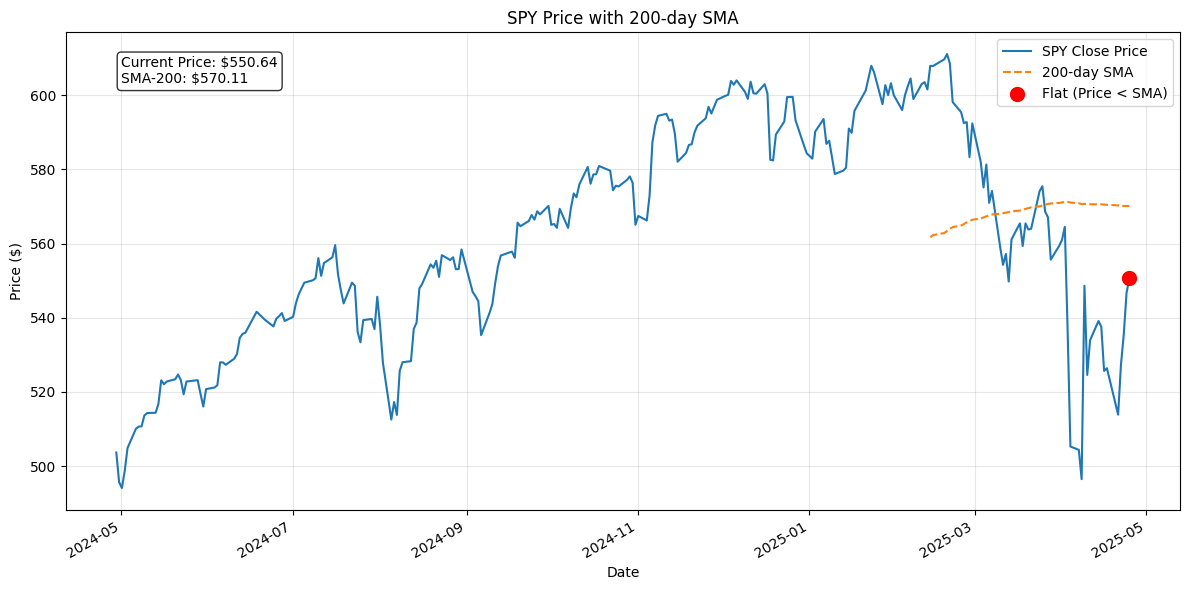

[Rate Limit] Sleeping for 11.58 seconds...
[Rate Limit] Sleeping for 12.00 seconds...
[Rate Limit] Sleeping for 12.00 seconds...


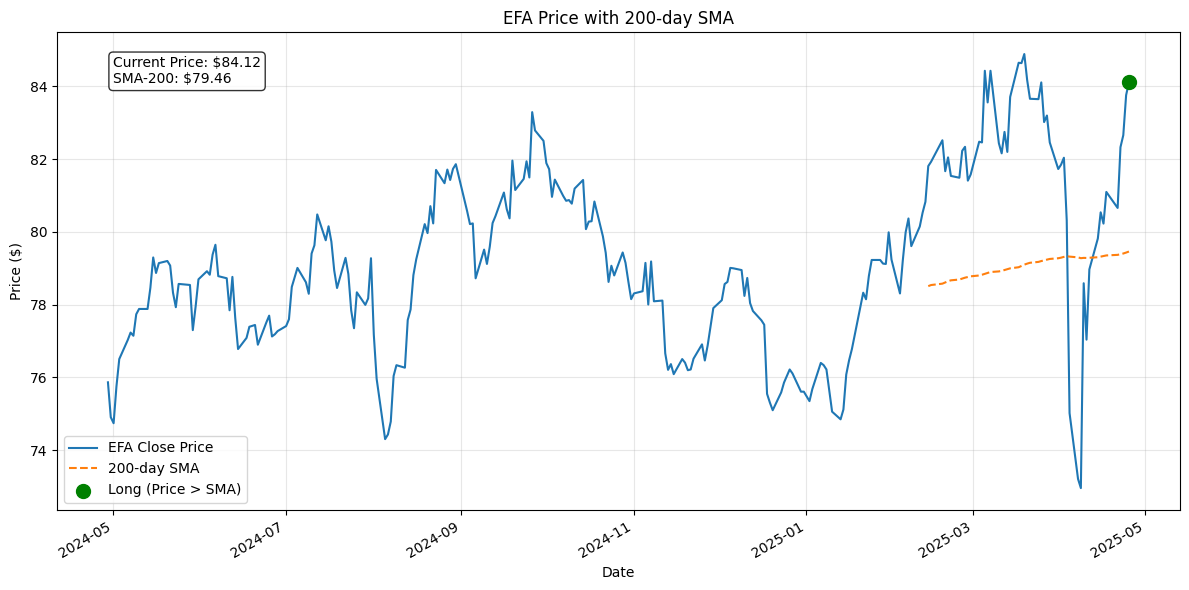

[Rate Limit] Sleeping for 11.70 seconds...
[Rate Limit] Sleeping for 12.00 seconds...
[Rate Limit] Sleeping for 12.00 seconds...


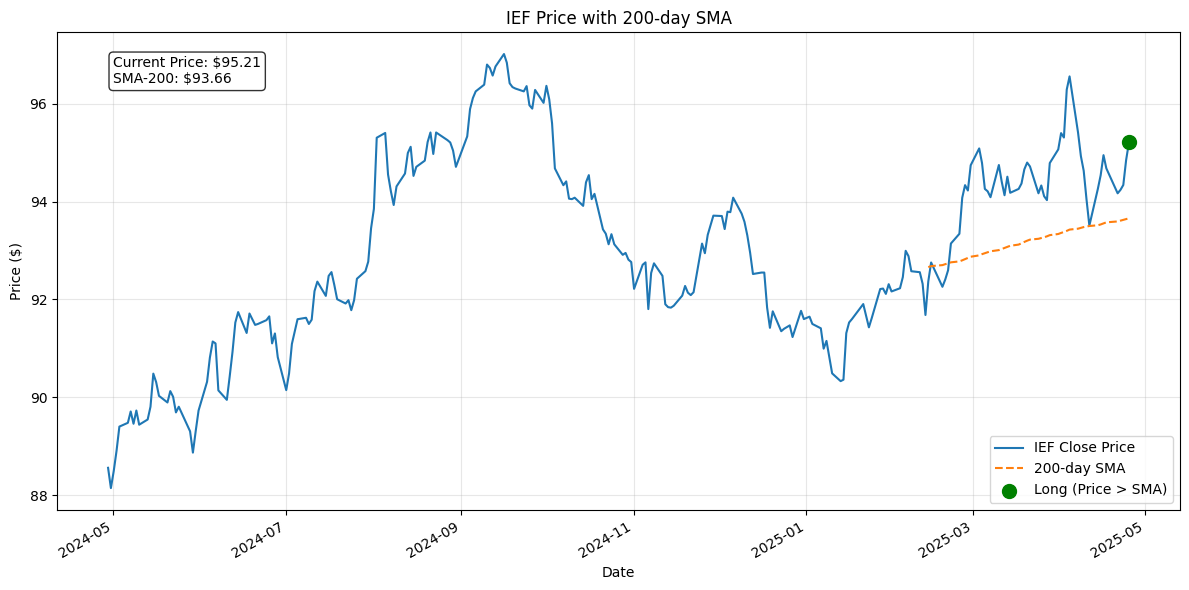

[Rate Limit] Sleeping for 11.56 seconds...
[Rate Limit] Sleeping for 12.00 seconds...
[Rate Limit] Sleeping for 12.00 seconds...


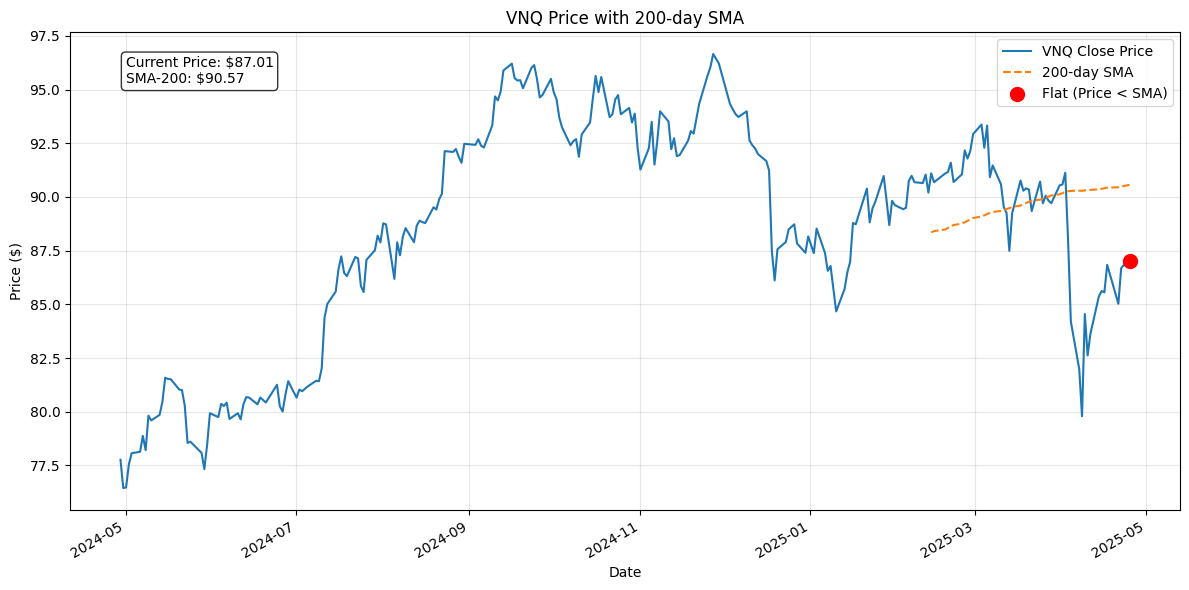

[Rate Limit] Sleeping for 11.67 seconds...
[Rate Limit] Sleeping for 12.00 seconds...
[Rate Limit] Sleeping for 12.00 seconds...


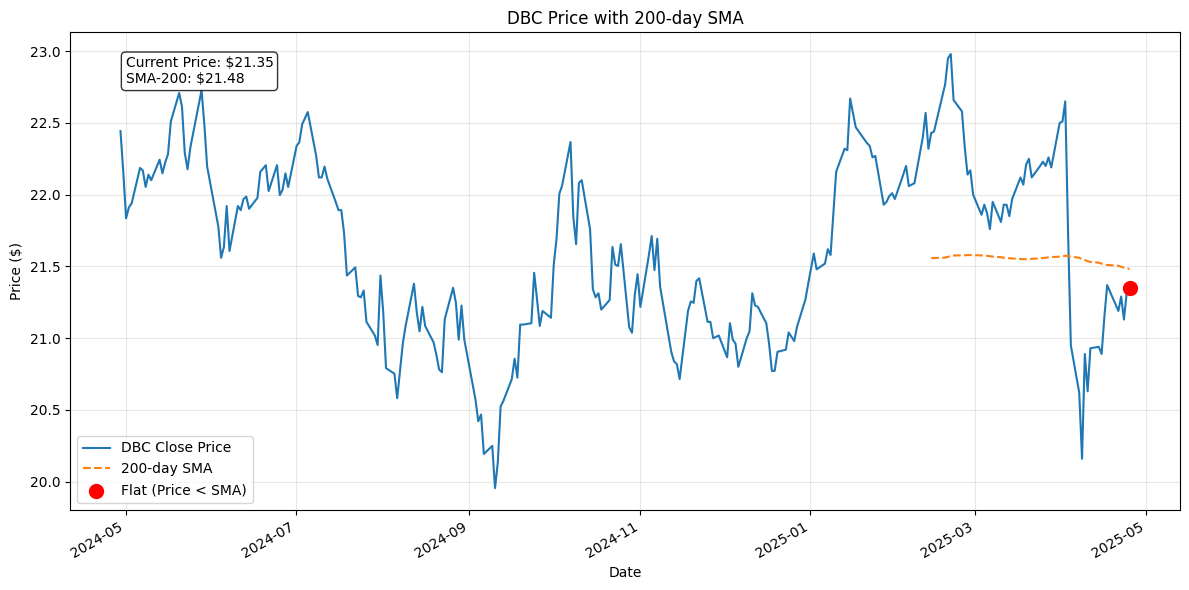

[Rate Limit] Sleeping for 11.71 seconds...
[Rate Limit] Sleeping for 12.00 seconds...
[Rate Limit] Sleeping for 12.00 seconds...


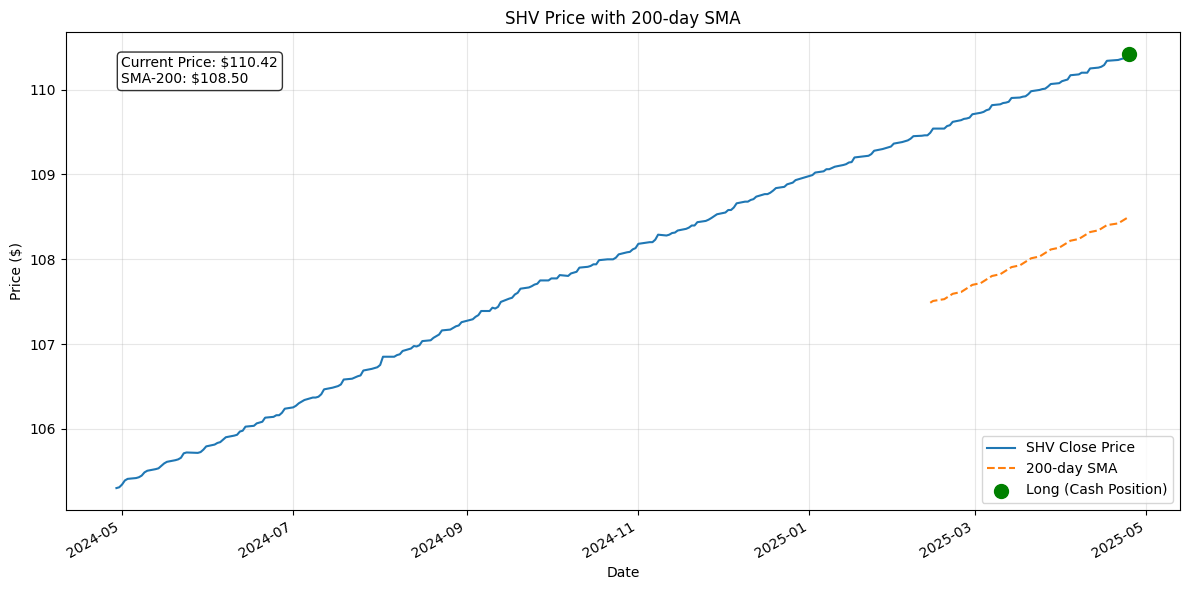


==== Trend Following Strategy Results ====

Ticker Signal Price    Weight   Current  Ideal    Trade    Notional    
----------------------------------------------------------------------
SPY    0      $550.64  0.00%    100      0        -100++++ $0.00       
EFA    1      $84.12   20.00%   100      237      137+++++ $19936.44   
IEF    1      $95.21   20.00%   100      210      110+++++ $19994.10   
VNQ    0      $87.01   0.00%    100      0        -100++++ $0.00       
DBC    0      $21.35   0.00%    100      0        -100++++ $0.00       
SHV    1      $110.42  60.07%   0        544      544+++++ $60068.48   


In [8]:
basket = []
tickers_data = portfolio_state["tickers_data"]
AUM = portfolio_state["aum"]

for tdata in tickers_data:
    ticker = tdata["ticker"]
    current_shares = tdata["current_shares"]

    data = polygon(ticker, from_date, to_date)

    if data.empty:
        continue

    data['sma'] = data['adjclose'].rolling(window=200, min_periods=200).mean()

    is_today = data['date'].iloc[-1].strftime('%Y-%m-%d') == today
    signal_data = data.iloc[:-1] if is_today else data

    signal_price = signal_data['adjclose'].iloc[-1]

    last_price = data['adjclose'].iloc[-1]

    sma_value = signal_data['sma'].dropna().iloc[-1] if not signal_data['sma'].dropna().empty else None

    if ticker == "SHV":
        signal = 1
    else:
        signal = int(signal_price > sma_value) if sma_value is not None else 0

    latest_date = data['date'].iloc[-1]
    plt.figure(figsize=(12, 6))
    plt.plot(data['date'], data['adjclose'], linewidth=1.5, label=f'{ticker} Close Price')
    plt.plot(data['date'], data['sma'], linestyle='--', linewidth=1.5, label='200-day SMA')

    if ticker == "SHV":
        plt.scatter([latest_date], [last_price], color='green', s=100, zorder=5, label='Long (Cash Position)')
    elif signal == 1:
        plt.scatter([latest_date], [last_price], color='green', s=100, zorder=5, label='Long (Price > SMA)')
    else:
        plt.scatter([latest_date], [last_price], color='red', s=100, zorder=5, label='Flat (Price < SMA)')

    plt.title(f'{ticker} Price with 200-day SMA')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.gcf().autofmt_xdate()

    textstr = f'Current Price: ${last_price:.2f}\nSMA-200: ${sma_value:.2f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black')
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)

    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    if ticker == "SHV":
        AUM_left = AUM - sum([b["ideal_notional"] for b in basket if "ideal_notional" in b])
        weight = AUM_left / AUM if AUM > 0 else 0
        ideal_shares = int(AUM_left / last_price)
    else:
        equal_weight = 1 / (len(tickers) - 1)
        weight = equal_weight * signal
        ideal_shares = int(equal_weight * (AUM * signal) / last_price)

    tdata["yclose"] = last_price
    tdata["signal"] = signal
    tdata["weight"] = weight
    tdata["ideal_shares"] = ideal_shares
    tdata["shares_to_trade"] = ideal_shares - current_shares
    tdata["ideal_notional"] = ideal_shares * last_price

    basket.append(tdata)

print("\n==== Trend Following Strategy Results ====\n")
print(f"{'Ticker':<6} {'Signal':<6} {'Price':<8} {'Weight':<8} {'Current':<8} {'Ideal':<8} {'Trade':<8} {'Notional':<12}")
print("-" * 70)
for t in basket:
    print(f"{t['ticker']:<6} {int(t['signal']):<6} ${t['yclose']:<7.2f} {t['weight']:<8.2%} {int(t['current_shares']):<8} {t['ideal_shares']:<8} {int(t['shares_to_trade']):+<8} ${t['ideal_notional']:<11.2f}")

# Step 4: Generate IBKR Basket File

Creates a `.csv` file that includes Market-On-Close (MOC) orders compatible with Trader Workstation's Basket Trader feature.  
**Make sure to enter your actual IB account ID in the `IB_ACCOUNT` variable below (e.g., "DU1234567").**  
This file can now be submitted manually using Trader Workstation’s Basket Trader tool (see Step 5 below), or you can automate it in Step 6.


In [9]:
# Replace this with your actual IB account ID (e.g., "DU1234567")
IB_ACCOUNT = "DUxxxxxxx"
csv_filename = "ibkr_basket_orders.csv"

ibkr_fields = [
    "Action", "Quantity", "Symbol", "SecType", "Exchange", "Currency",
    "TimeInForce", "OrderType", "LmtPrice", "BasketTag", "Account",
    "OutsideRTH", "OrderRef", "LastTradingDayOrContractMonth",
    "Strike", "Right", "DivPrt", "Multiplier"
]

with open(csv_filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=ibkr_fields)
    writer.writeheader()

    for t in basket:
        qty = int(t["shares_to_trade"])
        if qty == 0:
            continue

        writer.writerow({
            "Action": "BUY" if qty > 0 else "SELL",
            "Quantity": abs(qty),
            "Symbol": t["ticker"],
            "SecType": "STK",
            "Exchange": "SMART/ARCA",
            "Currency": "USD",
            "TimeInForce": "DAY",
            "OrderType": "MOC",
            "LmtPrice": "",
            "BasketTag": "Basket",
            "Account": IB_ACCOUNT,
            "OutsideRTH": "TRUE",
            "OrderRef": "Basket",
            "LastTradingDayOrContractMonth": "",
            "Strike": "",
            "Right": "",
            "DivPrt": "",
            "Multiplier": ""
        })

print(f"\nIBKR basket file saved: {csv_filename}")


IBKR basket file saved: ibkr_basket_orders.csv


# Step 5: Submit Orders via TWS (Manual Option)


Instructions to manually upload and transmit the basket orders:
1. Open Trader Workstation  
2. Go to: New Window → Basket Trader  
3. Browse and select the generated `.csv`  
4. Load and review the orders  
5. Click "Transmit" to submit them as a batch




# Step 6: Submit Orders via IBKR API (Automated Option)

> ⚠️ This step **must be run locally**. It **does not work on Google Colab**.

Before using the IBKR API, make sure Trader Workstation (TWS) or IB Gateway is configured to accept API connections:

1. Open **TWS** or **IB Gateway**
2. Go to:  
   **Configure → API → Settings**
3. Enable the checkbox:  
   **"Enable ActiveX and Socket Clients"**

### Port Configuration

Use the correct port based on your environment and platform:

| Platform     | Mode           | Port  |
|--------------|----------------|-------|
| TWS          | Paper Trading  | 7497  |
| TWS          | Live Trading   | 7496  |
| IB Gateway   | Paper Trading  | 4002  |
| IB Gateway   | Live Trading   | 4001  |

---

Use the IBKR API to:
- Connect to Trader Workstation or IB Gateway  
- Qualify contracts  
- Submit Market-On-Close (MOC) orders automatically


### 1. Connect to IBKR  
Start the async event loop and establish a connection to your local TWS or IB Gateway instance.


In [ ]:
util.startLoop()

ib = IB()
ib.connect('127.0.0.1', 7497, clientId=1)

### 2. Qualify Contracts  
Verify that each ETF ticker is a valid tradable instrument via IBKR’s system.

In [ ]:
tickers = [t["ticker"] for t in basket]
contracts = [Stock(ticker, 'SMART', 'USD') for ticker in tickers]
ib.qualifyContracts(*contracts)
contract_map = {contract.symbol: contract for contract in contracts}
contract_map

### 3. Submit Market-On-Close Orders  
For each asset, send a market-on-close order (BUY or SELL) based on the calculated rebalance.

In [ ]:
print("WARNING: This will place LIVE Market-On-Close (MOC) orders via IBKR.\n")

trades = []

print(f"{'TICKER':<10} {'ACTION':<6} {'QUANTITY':<10} {'ORDER ID':<10}")
print("-" * 50)

for item in basket:
    ticker = item["ticker"]
    shares_to_trade = int(item["shares_to_trade"])

    if shares_to_trade == 0:
        continue

    contract = contract_map[ticker]
    action = 'BUY' if shares_to_trade > 0 else 'SELL'
    qty = abs(shares_to_trade)

    order = Order(
        action=action,
        totalQuantity=qty,
        orderType='MOC',
        tif='DAY'
    )

    trade = ib.placeOrder(contract, order)

    print(f"{ticker:<10} {action:<6} {qty:<10} {trade.order.orderId:<10}")
    trades.append(trade)

print("\nAll Market-On-Close (MOC) orders have been submitted.")


In [ ]:
ib.disconnect()
